# Machine Learning Project
by Alexandre Waerniers and Vincent Lamy,

students at Albert School x Mines Paris PSL

In [60]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
from utils import cramers_v, plot_heatmap, compare_distributions, psi

# Get project path
cwd = os.getcwd()
print(cwd)

d:\ALBERTSCHOOL\SupervisedML\supervised_ml_project_waerniers_lamy


# Donwload datasets

In [61]:
# raw dataset
bank_full = pd.read_csv(os.path.join(cwd, "data", "bank-additional-full.csv"), sep=";")

bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# Data Exploration

In [62]:
def class_ratio(df, split_index):
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train['y'].value_counts(normalize=True).to_dict(), test['y'].value_counts(normalize=True).to_dict()


def compare_split_y_distribution(data):
    # Prepare lists
    pcts = []
    train_no, train_yes = [], []
    test_no, test_yes = [], []

    # Loop through test percentages
    for pct in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
        idx = int(len(data) * (1 - pct))
        train_ratio, test_ratio = class_ratio(data, idx)

        pcts.append(pct)
        train_no.append(train_ratio.get('no', 0))
        train_yes.append(train_ratio.get('yes', 0))
        test_no.append(test_ratio.get('no', 0))
        test_yes.append(test_ratio.get('yes', 0))

        print(f"test_pct={pct:>4}: "
            f"train_no={train_ratio['no']:.3f}, train_yes={train_ratio['yes']:.3f} | "
            f"test_no={test_ratio['no']:.3f}, test_yes={test_ratio['yes']:.3f}")

    x = np.arange(len(pcts))
    width = 0.2

    plt.figure(figsize=(10, 6))

    # Train bars
    plt.bar(x - width, train_no, width, label='Train - No', color='steelblue')
    plt.bar(x - width, train_yes, width, bottom=train_no, alpha=0.3, color='steelblue')

    # Test bars
    plt.bar(x + width, test_no, width, label='Test - No', color='darkorange')
    plt.bar(x + width, test_yes, width, bottom=test_no, alpha=0.3, color='darkorange')

    # Aesthetics
    plt.xticks(x, [f"{int(p*100)}%" for p in pcts])
    plt.xlabel("Test Set Percentage")
    plt.ylabel("Class Ratio (0–1)")
    plt.title("Class Ratio Distribution (Train vs Test)")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


test_pct=0.05: train_no=0.909, train_yes=0.091 | test_no=0.479, test_yes=0.521
test_pct= 0.1: train_no=0.926, train_yes=0.074 | test_no=0.541, test_yes=0.459
test_pct=0.15: train_no=0.935, train_yes=0.065 | test_no=0.615, test_yes=0.385
test_pct= 0.2: train_no=0.936, train_yes=0.064 | test_no=0.692, test_yes=0.308
test_pct=0.25: train_no=0.936, train_yes=0.064 | test_no=0.742, test_yes=0.258
test_pct= 0.3: train_no=0.944, train_yes=0.056 | test_no=0.754, test_yes=0.246
test_pct=0.35: train_no=0.952, train_yes=0.048 | test_no=0.768, test_yes=0.232


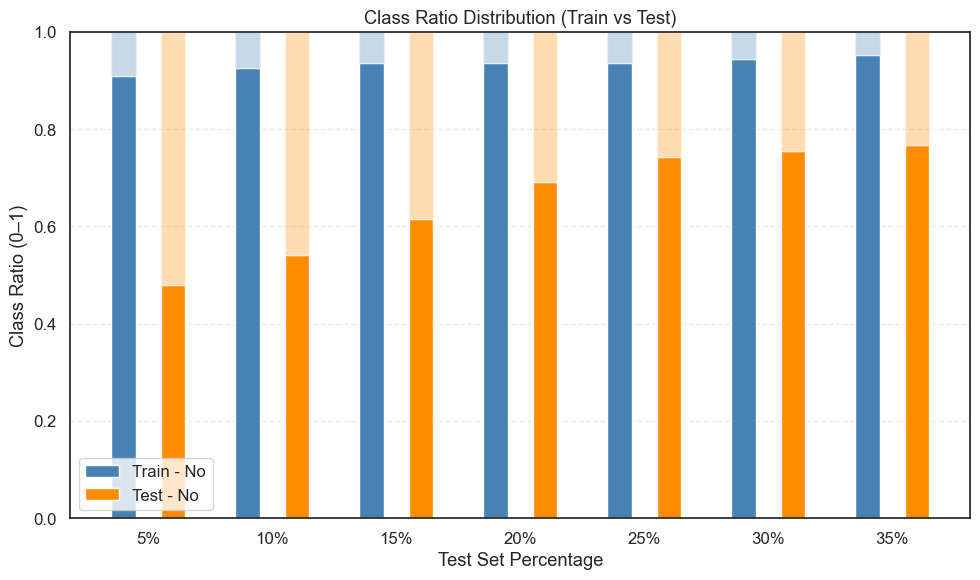

In [63]:
compare_split_y_distribution(bank_full)

The target repartition is **strongly imbalanced** in the training set and doesn't match the repartition of the test set. It means that they do not come from the same populations and that a **serious drift occured**.

This situation is a bit problematic and will be difficult to handle since the notion of time is included (we realised that a bit too late).

Anyways, we know a few methods to overcome this problem and we will put them in place.

For now, we define the **split to be at 25% test split**. It is a good compromise.

# Data Split

In [64]:
train_size = 0.75
split = int(len(bank_full)*train_size)

train_set = bank_full.iloc[:split].copy()
test_set = bank_full.iloc[split:].copy()

# Features distribution between train and test sets

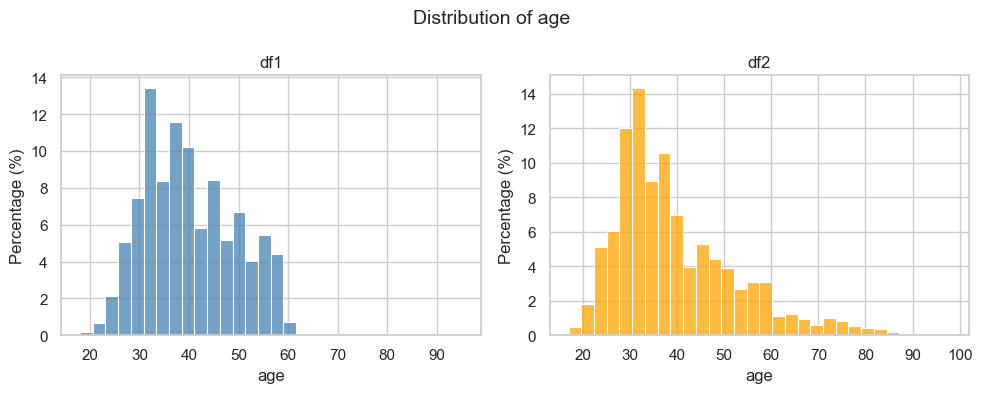

Bins for 'age': [18.         20.56666667 23.13333333 25.7        28.26666667 30.83333333
 33.4        35.96666667 38.53333333 41.1        43.66666667 46.23333333
 48.8        51.36666667 53.93333333 56.5        59.06666667 61.63333333
 64.2        66.76666667 69.33333333 71.9        74.46666667 77.03333333
 79.6        82.16666667 84.73333333 87.3        89.86666667 92.43333333
 95.        ]


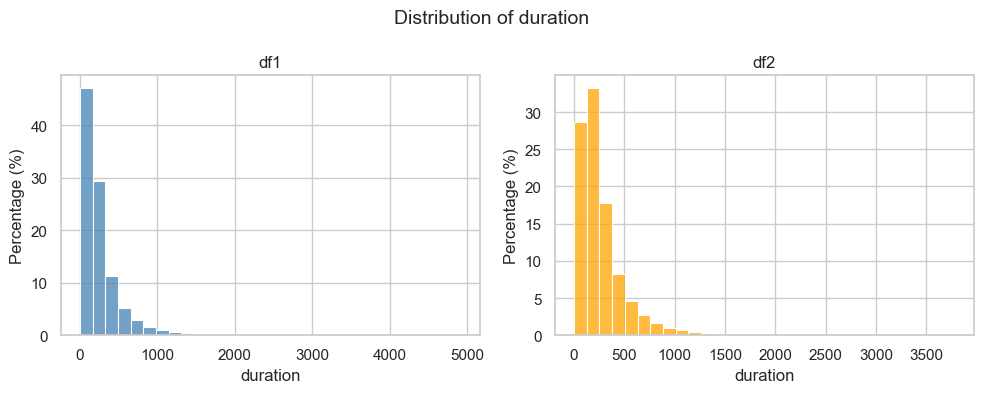

Bins for 'duration': [   0.          163.93333333  327.86666667  491.8         655.73333333
  819.66666667  983.6        1147.53333333 1311.46666667 1475.4
 1639.33333333 1803.26666667 1967.2        2131.13333333 2295.06666667
 2459.         2622.93333333 2786.86666667 2950.8        3114.73333333
 3278.66666667 3442.6        3606.53333333 3770.46666667 3934.4
 4098.33333333 4262.26666667 4426.2        4590.13333333 4754.06666667
 4918.        ]


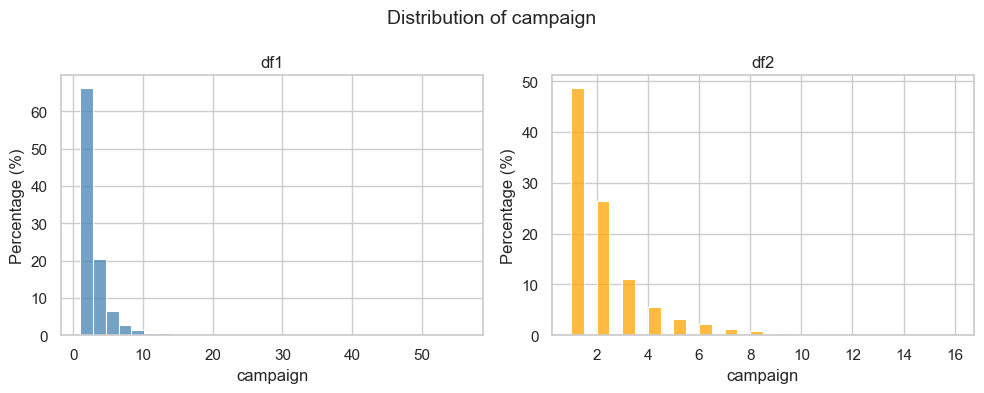

Bins for 'campaign': [ 1.          2.83333333  4.66666667  6.5         8.33333333 10.16666667
 12.         13.83333333 15.66666667 17.5        19.33333333 21.16666667
 23.         24.83333333 26.66666667 28.5        30.33333333 32.16666667
 34.         35.83333333 37.66666667 39.5        41.33333333 43.16666667
 45.         46.83333333 48.66666667 50.5        52.33333333 54.16666667
 56.        ]


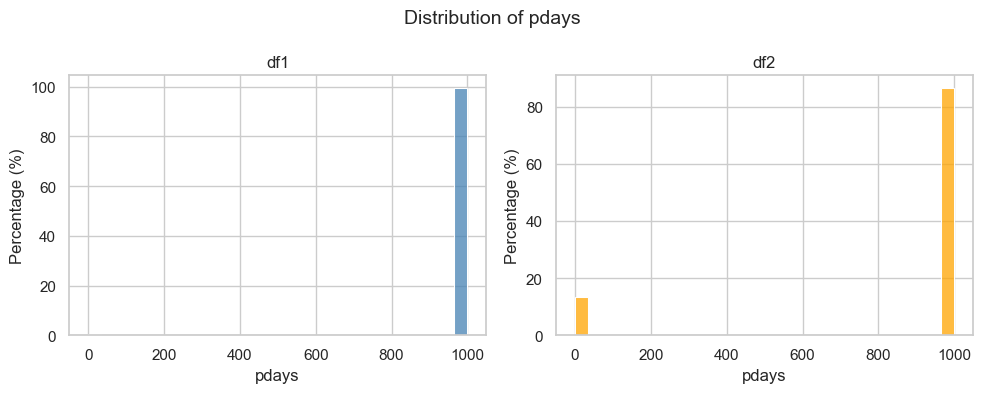

Bins for 'pdays': [  0.   33.3  66.6  99.9 133.2 166.5 199.8 233.1 266.4 299.7 333.  366.3
 399.6 432.9 466.2 499.5 532.8 566.1 599.4 632.7 666.  699.3 732.6 765.9
 799.2 832.5 865.8 899.1 932.4 965.7 999. ]


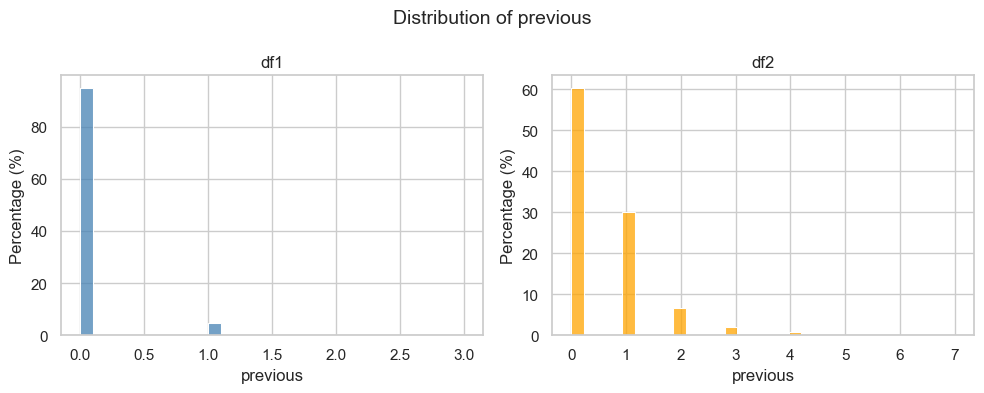

Bins for 'previous': [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]


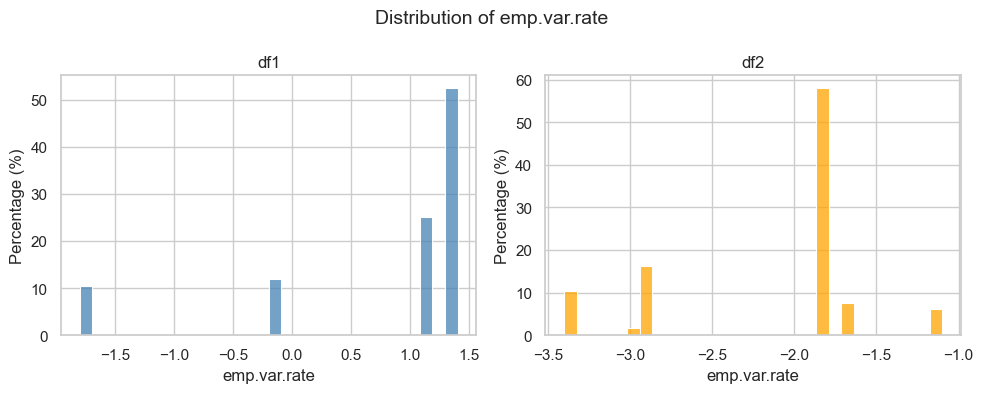

Bins for 'emp.var.rate': [-1.8        -1.69333333 -1.58666667 -1.48       -1.37333333 -1.26666667
 -1.16       -1.05333333 -0.94666667 -0.84       -0.73333333 -0.62666667
 -0.52       -0.41333333 -0.30666667 -0.2        -0.09333333  0.01333333
  0.12        0.22666667  0.33333333  0.44        0.54666667  0.65333333
  0.76        0.86666667  0.97333333  1.08        1.18666667  1.29333333
  1.4       ]


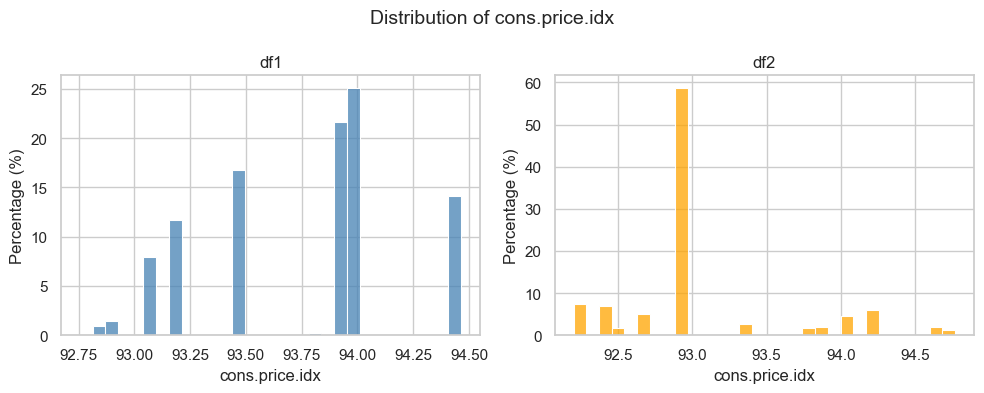

Bins for 'cons.price.idx': [92.756      92.81296667 92.86993333 92.9269     92.98386667 93.04083333
 93.0978     93.15476667 93.21173333 93.2687     93.32566667 93.38263333
 93.4396     93.49656667 93.55353333 93.6105     93.66746667 93.72443333
 93.7814     93.83836667 93.89533333 93.9523     94.00926667 94.06623333
 94.1232     94.18016667 94.23713333 94.2941     94.35106667 94.40803333
 94.465     ]


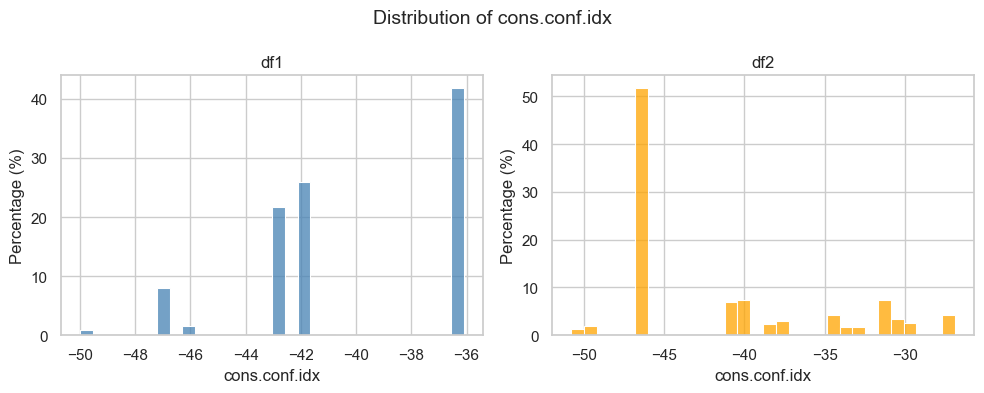

Bins for 'cons.conf.idx': [-50.         -49.53666667 -49.07333333 -48.61       -48.14666667
 -47.68333333 -47.22       -46.75666667 -46.29333333 -45.83
 -45.36666667 -44.90333333 -44.44       -43.97666667 -43.51333333
 -43.05       -42.58666667 -42.12333333 -41.66       -41.19666667
 -40.73333333 -40.27       -39.80666667 -39.34333333 -38.88
 -38.41666667 -37.95333333 -37.49       -37.02666667 -36.56333333
 -36.1       ]


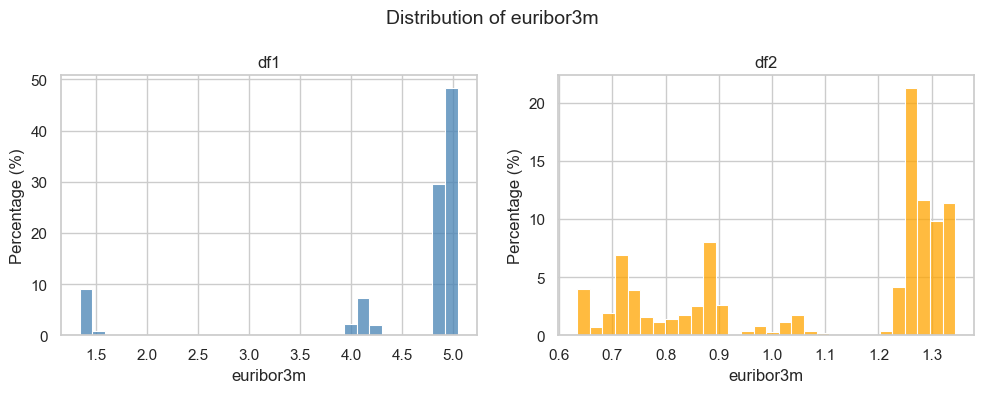

Bins for 'euribor3m': [1.344      1.46736667 1.59073333 1.7141     1.83746667 1.96083333
 2.0842     2.20756667 2.33093333 2.4543     2.57766667 2.70103333
 2.8244     2.94776667 3.07113333 3.1945     3.31786667 3.44123333
 3.5646     3.68796667 3.81133333 3.9347     4.05806667 4.18143333
 4.3048     4.42816667 4.55153333 4.6749     4.79826667 4.92163333
 5.045     ]


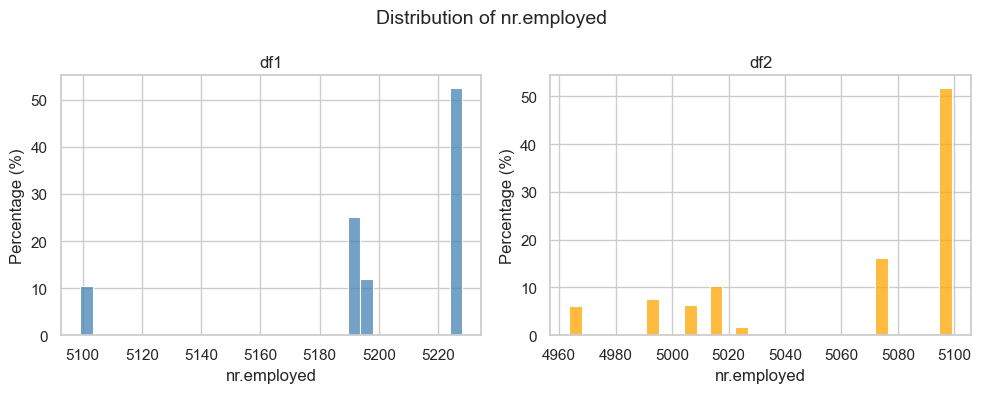

Bins for 'nr.employed': [5099.1 5103.4 5107.7 5112.  5116.3 5120.6 5124.9 5129.2 5133.5 5137.8
 5142.1 5146.4 5150.7 5155.  5159.3 5163.6 5167.9 5172.2 5176.5 5180.8
 5185.1 5189.4 5193.7 5198.  5202.3 5206.6 5210.9 5215.2 5219.5 5223.8
 5228.1]


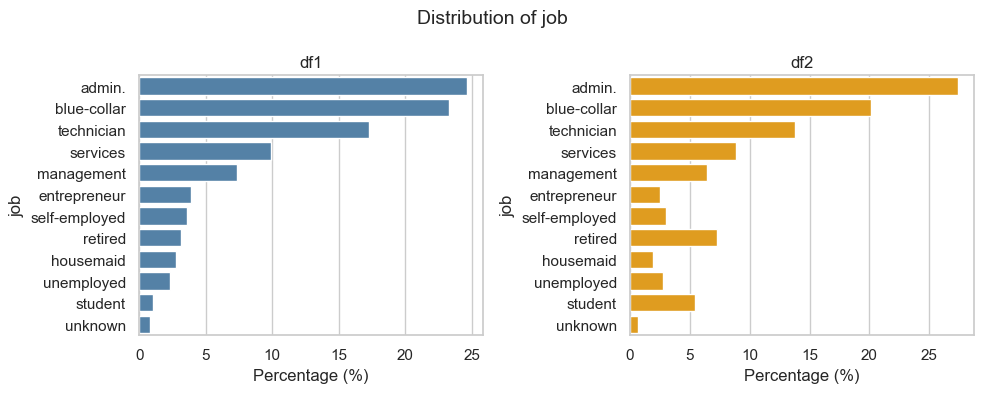

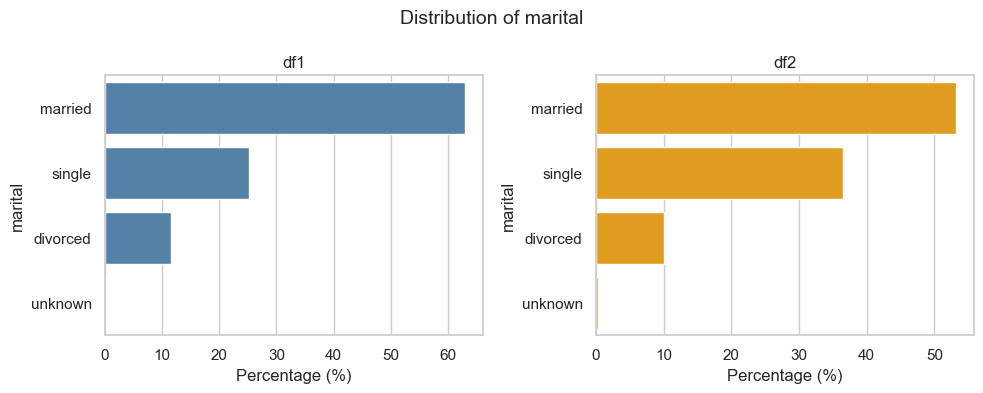

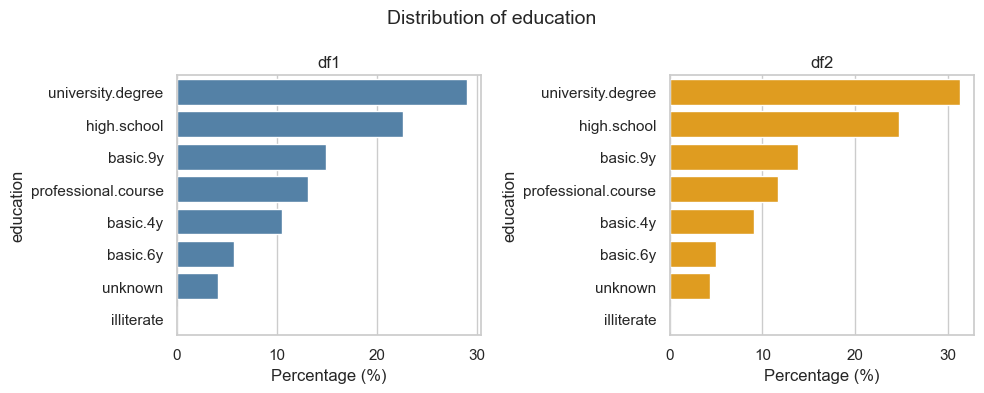

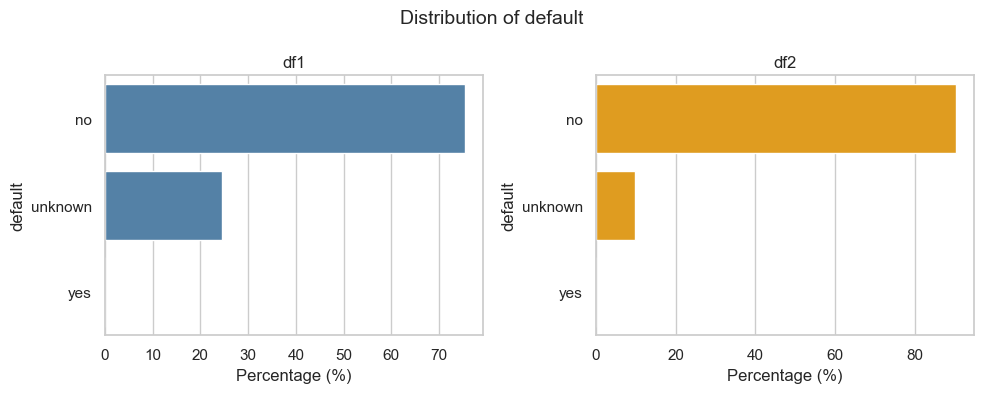

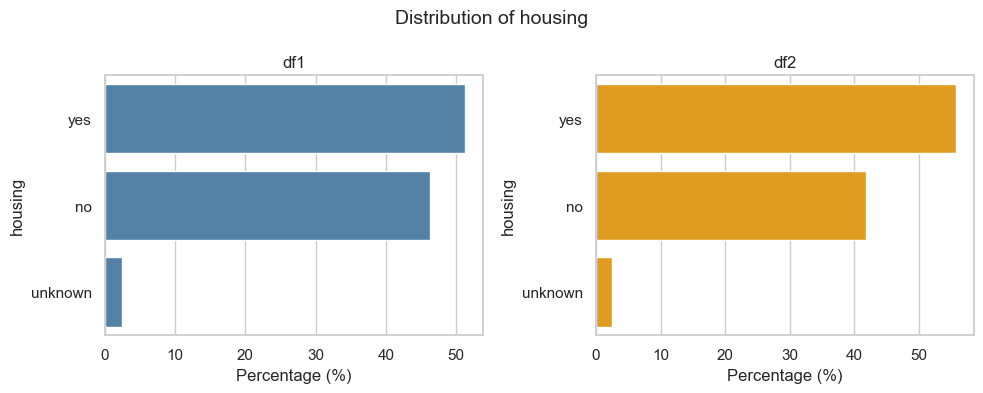

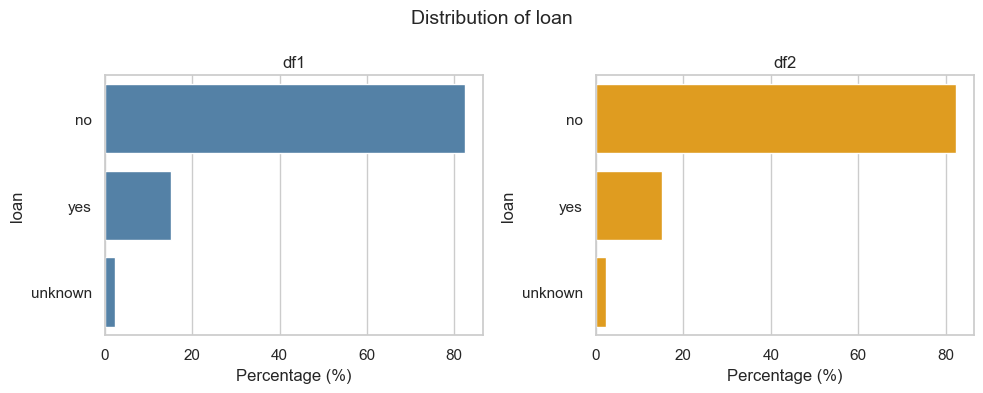

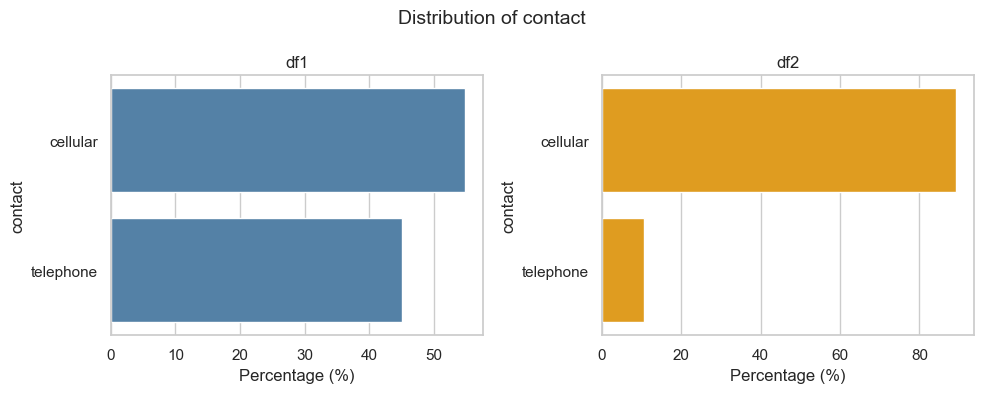

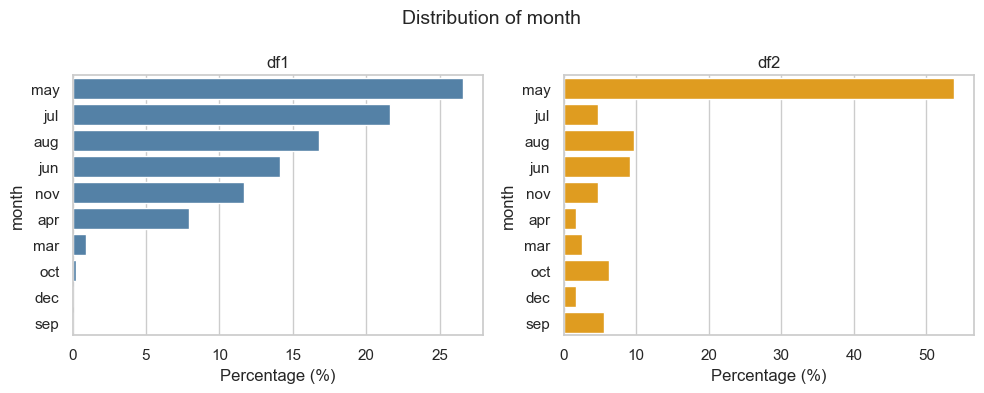

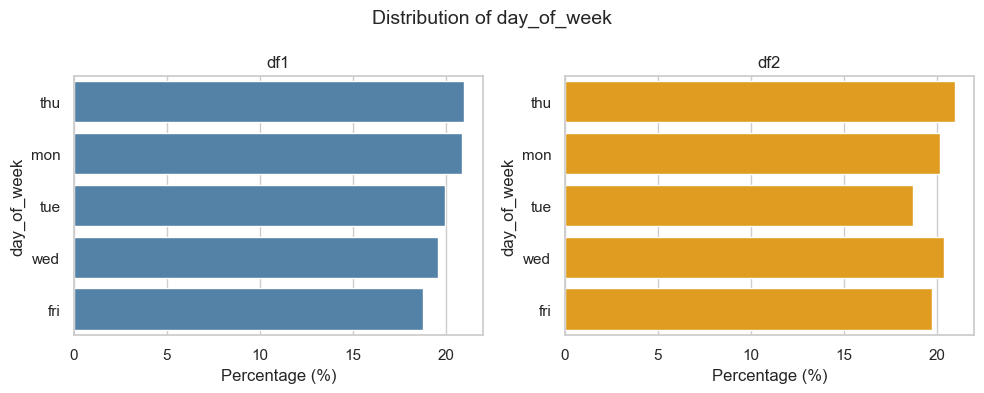

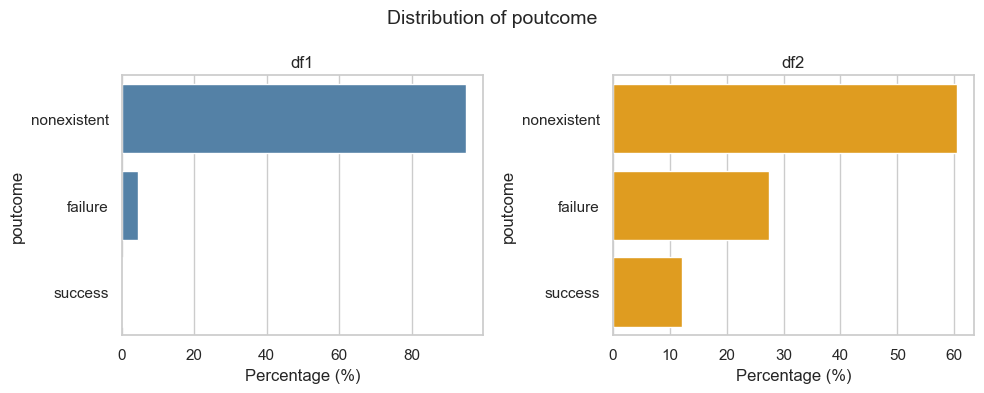

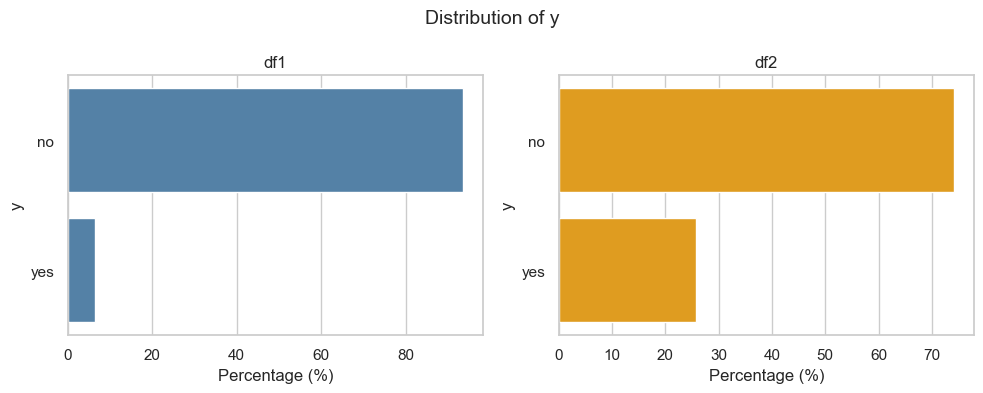

In [65]:
compare_distributions(train_set, test_set, 30)

In [66]:
num_cols = train_set.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train_set.select_dtypes(include=["category", "object"]).columns.tolist()

print(num_cols)
print(cat_cols)

results = []

# Compute PSI - num
for col in num_cols:
    psi_val = psi(train_set[col].dropna(), test_set[col].dropna(), n_bins=30)
    results.append([col, psi_val])

# Compute PSI - cat
for col in cat_cols:
    psi_val = psi(train_set[col], test_set[col], n_bins=30)
    results.append([col, psi_val])

psi_outputs = pd.DataFrame(results, columns=["Feature", "Psi"])
psi_outputs

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


,Feature,Psi
0,age,0.352378
1,duration,0.022452
2,campaign,0.081058
3,pdays,0.461901
4,previous,0.940028
5,emp.var.rate,8.727344
6,cons.price.idx,10.530461
7,cons.conf.idx,10.678185
8,euribor3m,7.361996
9,nr.employed,7.978768


### Distributions Analysis : 

From the plots and the psi outputs we can witness a big data drift for multiple features.

significant drift : age, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, month, poutcome, y

moderate drift : default

# Correlation Matrix

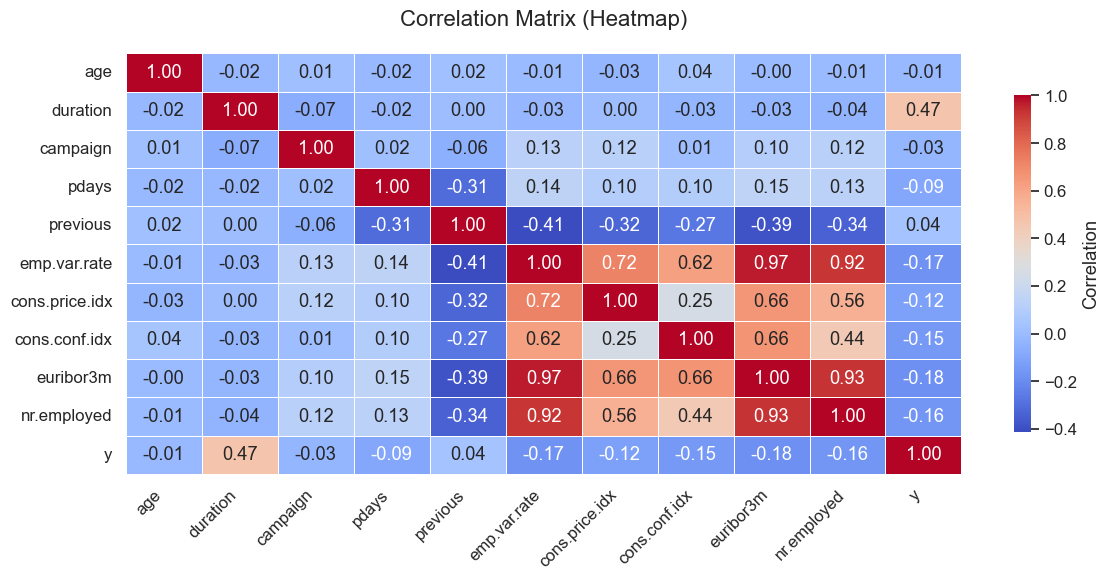

In [67]:
data = train_set.copy()
data.y = data.y.map({"yes": 1, "no": 0})
num_cols = data.select_dtypes(include=["number"]).columns.tolist()

corr = data[num_cols].corr(method="pearson")
"""
Pearson :   Linear correlation,
            Measures how well two variables follow a straight-line relationship,
            Works best for continuous, normally distributed data, 
            Sensitive to outliers.
Spearman :  Rank correlation,
            Measures how well the rank order of values matches between variables, 
            Works best for monotonic relationships (increasing or decreasing, not necessarily linear),
            Fewer outliers.
"""

plot_heatmap(corr, "Correlation Matrix (Heatmap)")

### Observations :

| Feature Pair                      | Correlation | Explanation                                                                                                                                                                      |
| --------------------------------- | ----------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **emp.var.rate ↔ euribor3m**      | **0.97**    | Extremely high. Both are macroeconomic indicators that move together over time. A higher employment variation rate often coincides with higher euribor rates (economic cycles). |
| **emp.var.rate ↔ nr.employed**    | **0.92**    | Also very strong. As employment rate increases, total number of employees in the economy rises. Same underlying macroeconomic dynamic.                                          |
| **euribor3m ↔ nr.employed**       | **0.93**    | Same story, macro variables capturing similar trends; very collinear.                                                                                                           |
| **emp.var.rate ↔ cons.price.idx** | **0.72**    | Positive relationship. Better employment conditions typically correlate with higher consumer prices.                                                                            |
| **previous ↔ pdays**              | **-0.31**   | Moderate negative correlation. if many days passed since the last contact, there tend to be fewer previous contacts (and vice versa).                                           |
| **duration ↔ y**                  | **0.47**    | Strongest correlation with the target, call duration is a sign of interest.                                             |




### Decisions :
- **emp.var.rate** , **euribor3m** and **nr.employed** are all strongly correltated (> 0.9) because these variables describe the same macroeconomic state (growth vs. recession). We may consider keeping only one or applying PCA to combine them.

- **previous** and **pdays** are campaign history features, and they’re engineered from the same logic, so their negative correlation is expected. They reflect how recently and how often a client was contacted. Redundancy won't affect tree-based model but still, we decided to drop pdays because we will also use Linear Models.

- **duration** correlates with **y** because it's a consequence not a cause (data leakage). We will not use it in order to build a realistc predictive model.


# Categorical features dependency w/ Cramer's V

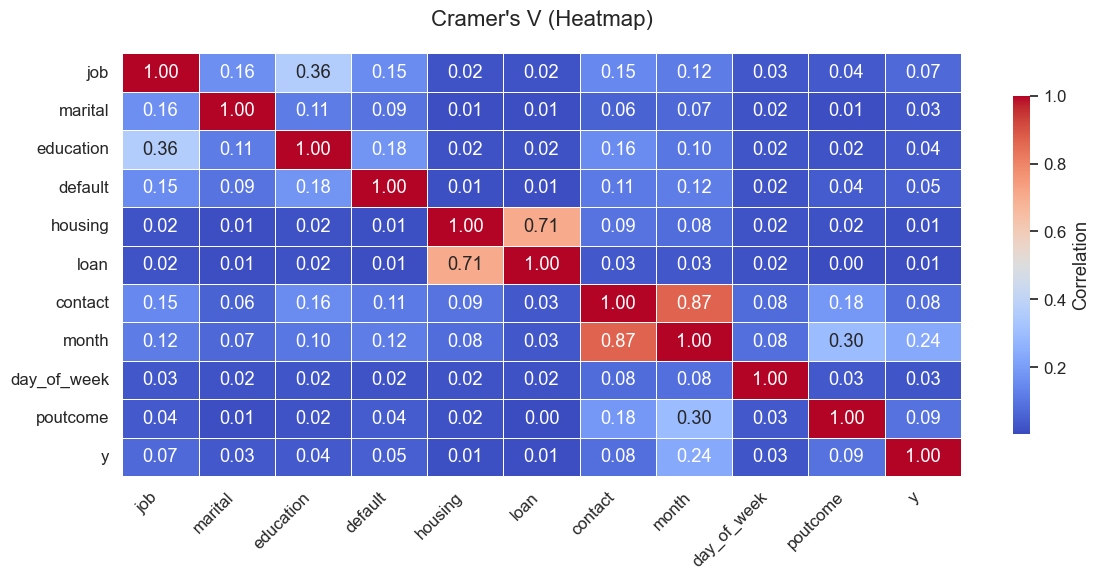

In [68]:
data = train_set.copy()
cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()
bank_cat = data[cat_cols]

cramers_outputs = [[cramers_v(bank_cat[col_i], bank_cat[col_j]) for col_j in cat_cols] for col_i in cat_cols]

cramers_df = pd.DataFrame(cramers_outputs, columns = cat_cols, index = cat_cols)
plot_heatmap(cramers_df, "Cramer's V (Heatmap)")

### Observations :

| **Feature Pair**               | **Strength**    | **Explanation**                                                                                                                                      |
| ------------------------------ | --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| **housing ↔ loan**             | Strong          | Both indicate financial obligations. Clients with housing loans often also have personal loans, showing correlated credit behavior.                 |
| **month ↔ contact**            | Strong          | Contact type evolved over time : earlier campaigns used telephone, later ones used cellular; reflects a time-dependent communication strategy.       |
| **job ↔ education**            | Moderate        | Job type naturally depends on education level; higher education aligns with professional roles, lower education with manual or service jobs.         |


### Decisions :

- **housing ↔ loan** are partially redundant, they represent a similar financial dimension. We will only keep one to avoid redundancy.

- **month ↔ contact** The bank’s communication strategy evolved, early months relied more on landline (telephone), while later months used cellular contacts as mobile adoption grew.

- **job ↔ education** This is an expected natural correlation, not problematic.

# Summary

- **target imbalanced** : Need to use undersampling and/or importance weighting

- **distribution drift for many features** : Only keep the ones that are managable

- **strong internal correlations among macroeconomic features** : Only keep nr.employed because it is the less affected by drifting

- **low overall predictive linearity** : most features are weakly correlated, implying the need for non-linear models

- **data looks consistent** : no signs of anomalies, relationships match economic logic

# Adaptation

In [69]:
unique_months = bank_full.month.unique().tolist()

for m in unique_months:

    condition = bank_full['month'] == m
    groups = (condition != condition.shift()).cumsum()
    ranges = []
    for g, idx in bank_full[condition].groupby(groups[condition]).groups.items():
        start, end = idx.min(), idx.max()
        ranges.append((start, end))

    print(m, ranges)

may [(0, 7762), (30430, 36223), (39568, 39779)]
jun [(7763, 12136), (36224, 36938), (39780, 40008)]
jul [(12137, 18821), (36939, 37116), (40009, 40319)]
aug [(18822, 23996), (37117, 37886), (40320, 40552)]
oct [(23997, 24063), (38154, 38600), (40856, 41059)]
nov [(24064, 27679), (38601, 38957), (41060, 41187)]
dec [(27680, 27689), (38958, 39129)]
mar [(27690, 27971), (39130, 39393)]
apr [(27972, 30429), (39394, 39567)]
sep [(37887, 38153), (40553, 40855)]


2008 : (start) 0 ->30429

2009 : 30430 - 39567

2010 : 39568 -> 41187 (end)

In [70]:
# Add year column to spot when the drifting started
bank_adapt = bank_full.copy()

bank_adapt["year"] = ""

bank_adapt.loc[:30429, "year"] = "2008"
bank_adapt.loc[30430:39567, "year"] = "2009"
bank_adapt.loc[39568:, "year"] = "2010"
bank_adapt.year.isna().sum()

0

In [71]:
def stacked_bar_plot(data, feature):
    
    # Create a mapping for month names to numbers
    month_order = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }

    # Add a numeric month column for sorting
    data['month_num'] = data['month'].str.lower().map(month_order)
    
    # Sort by year and numeric month
    data = data.sort_values(["year", "month_num"])

    # Group by year, month, and the specified feature
    grouped = data.groupby(["year", "month"])[feature].value_counts().unstack(fill_value=0)
    grouped = grouped.reset_index()

    # Sort the grouped data
    grouped['month_num'] = grouped['month'].str.lower().map(month_order)
    grouped = grouped.sort_values(["year", "month_num"])

    # Get all category columns (exclude year, month, month_num)
    category_cols = [col for col in grouped.columns if col not in ['year', 'month', 'month_num']]
    
    # Calculate total and percentages for each category
    grouped['total'] = grouped[category_cols].sum(axis=1)
    
    for col in category_cols:
        grouped[f'{col}_pct'] = (grouped[col] / grouped['total']) * 100

    grouped["period"] = grouped["year"].astype(str) + "-" + grouped["month"]

    # Create the plot
    plt.figure(figsize=(10,6))
    
    # Generate colors for each category
    colors = plt.cm.tab10(range(len(category_cols)))
    
    # Plot stacked bars
    bottom = None
    for i, col in enumerate(category_cols):
        plt.bar(grouped["period"], grouped[f'{col}_pct'], 
                label=col, color=colors[i], bottom=bottom)
        if bottom is None:
            bottom = grouped[f'{col}_pct']
        else:
            bottom += grouped[f'{col}_pct']

    plt.title(f"Percentage Distribution of '{feature}' by Month and Year")
    plt.xlabel("Year-Month")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

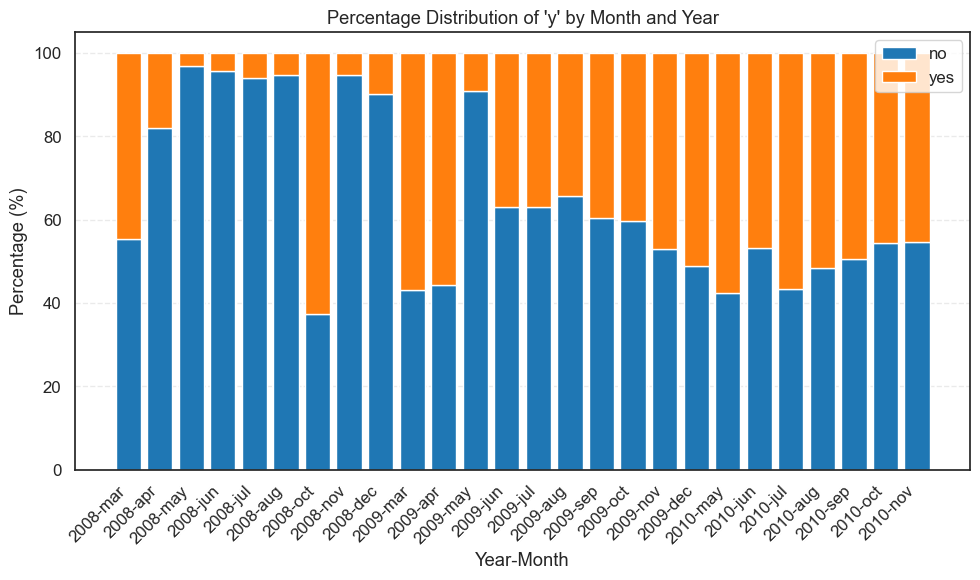

In [72]:
stacked_bar_plot(bank_adapt, "y")

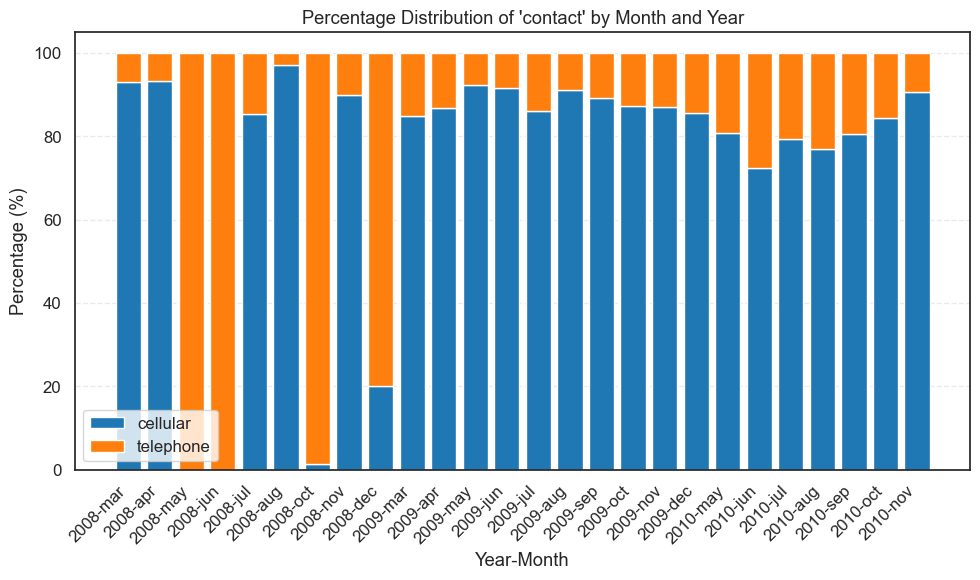

In [73]:
stacked_bar_plot(bank_adapt, 'contact')

### Observation :

We can clearly see the data drift started after may 2009.

Let's remember that the subprime crisis had a long time effect on banks and our dataset perfectly covers this period. The tendency for people to subscribe to a long term deposit for a Portuguese bank might have been affected by that period of financial uncertainty. Moreover, that booming of cellular phones use could be another source of major impact and amplify the data drift.

### Decision :

We decide to only base our analysis on what happened after that period since the dataset is chronologically ordered. Hence, we can only test on the latest data of the dataset to avoid data leakage.

To that effect, we will only use the data population that stays stable during time : from march 2009 to november 2010.

# Analysis on cut dataset

In [74]:
first_idx = int(bank_adapt[(bank_adapt.year == "2009") & (bank_adapt.month == "mar")].head(1).index[0])
first_idx

bank_cut = bank_full.iloc[first_idx:].reset_index(drop=True)
print(first_idx)
bank_cut

39130


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39,admin.,single,university.degree,no,yes,no,telephone,mar,mon,...,1,999,1,failure,-1.8,93.369,-34.8,0.655,5008.7,yes
1,60,technician,married,university.degree,no,yes,no,telephone,mar,mon,...,1,999,0,nonexistent,-1.8,93.369,-34.8,0.655,5008.7,no
2,30,blue-collar,married,high.school,no,yes,no,telephone,mar,tue,...,1,999,0,nonexistent,-1.8,93.369,-34.8,0.655,5008.7,yes
3,78,retired,divorced,professional.course,no,yes,no,cellular,mar,tue,...,1,999,1,failure,-1.8,93.369,-34.8,0.655,5008.7,yes
4,66,retired,married,basic.4y,no,yes,no,cellular,mar,tue,...,1,6,1,success,-1.8,93.369,-34.8,0.655,5008.7,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
2054,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
2055,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
2056,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


test_pct=0.05: train_no=0.477, train_yes=0.523 | test_no=0.505, test_yes=0.495
test_pct= 0.1: train_no=0.476, train_yes=0.524 | test_no=0.505, test_yes=0.495
test_pct=0.15: train_no=0.468, train_yes=0.532 | test_no=0.540, test_yes=0.460
test_pct= 0.2: train_no=0.460, train_yes=0.540 | test_no=0.553, test_yes=0.447
test_pct=0.25: train_no=0.467, train_yes=0.533 | test_no=0.515, test_yes=0.485
test_pct= 0.3: train_no=0.458, train_yes=0.542 | test_no=0.528, test_yes=0.472
test_pct=0.35: train_no=0.450, train_yes=0.550 | test_no=0.531, test_yes=0.469


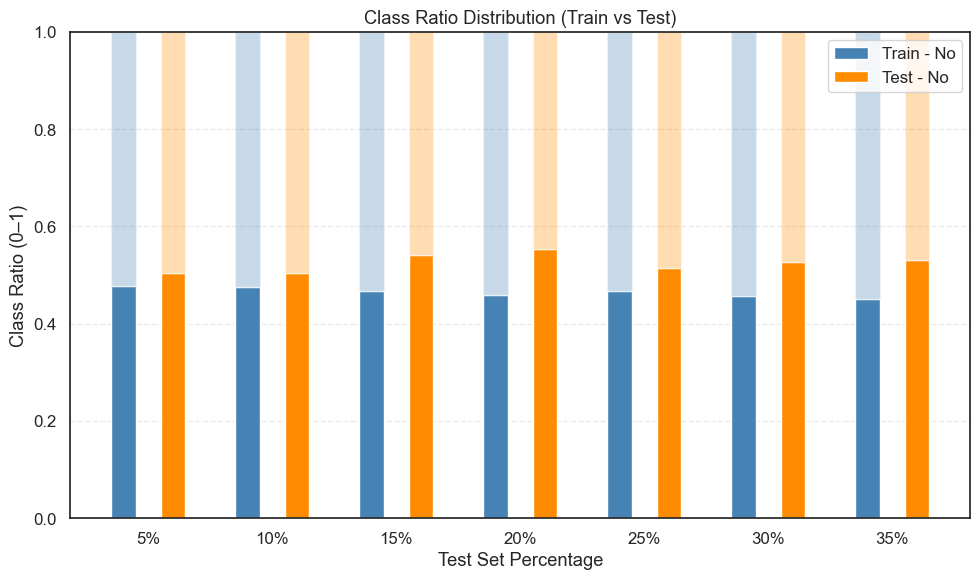

In [75]:
compare_split_y_distribution(bank_cut)

### Observation :

As expected, the target distribution is now much more similar in train and test datasets.

In [76]:
train_size = 0.8
split = int(len(bank_cut)*train_size)

train_set_cut = bank_cut.iloc[:split].copy()
test_set_cut = bank_cut.iloc[split:].copy()

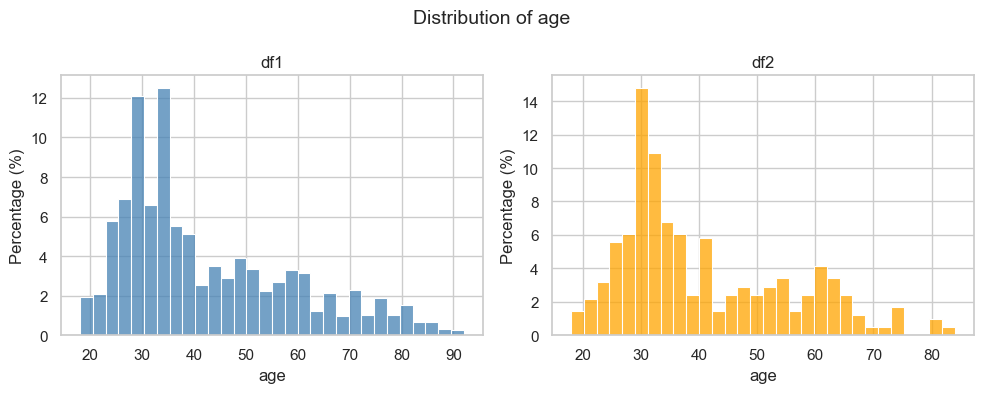

Bins for 'age': [18.         20.46666667 22.93333333 25.4        27.86666667 30.33333333
 32.8        35.26666667 37.73333333 40.2        42.66666667 45.13333333
 47.6        50.06666667 52.53333333 55.         57.46666667 59.93333333
 62.4        64.86666667 67.33333333 69.8        72.26666667 74.73333333
 77.2        79.66666667 82.13333333 84.6        87.06666667 89.53333333
 92.        ]


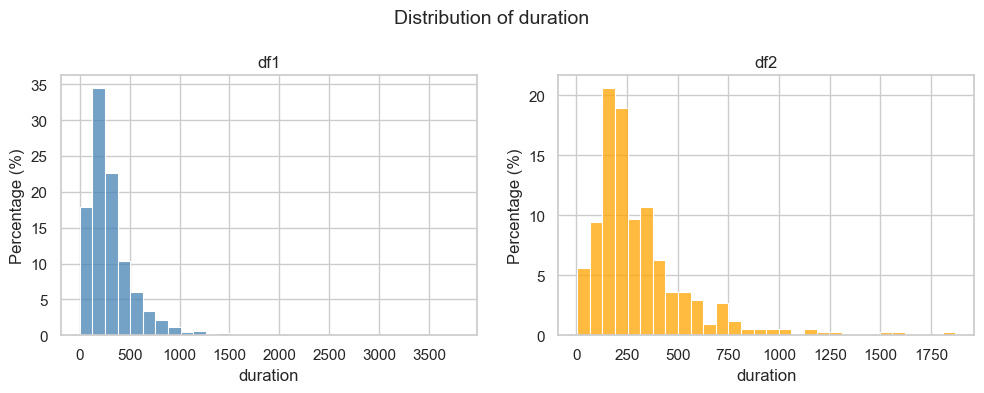

Bins for 'duration': [1.00000000e+00 1.27133333e+02 2.53266667e+02 3.79400000e+02
 5.05533333e+02 6.31666667e+02 7.57800000e+02 8.83933333e+02
 1.01006667e+03 1.13620000e+03 1.26233333e+03 1.38846667e+03
 1.51460000e+03 1.64073333e+03 1.76686667e+03 1.89300000e+03
 2.01913333e+03 2.14526667e+03 2.27140000e+03 2.39753333e+03
 2.52366667e+03 2.64980000e+03 2.77593333e+03 2.90206667e+03
 3.02820000e+03 3.15433333e+03 3.28046667e+03 3.40660000e+03
 3.53273333e+03 3.65886667e+03 3.78500000e+03]


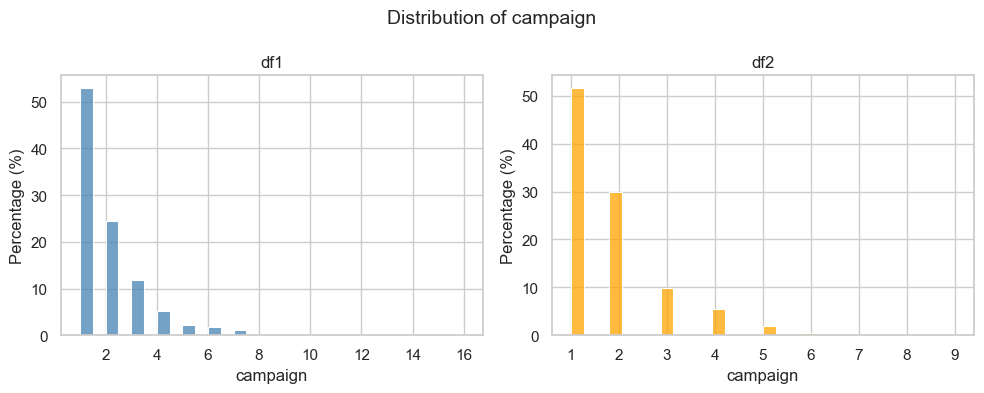

Bins for 'campaign': [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5
  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5
 15.  15.5 16. ]


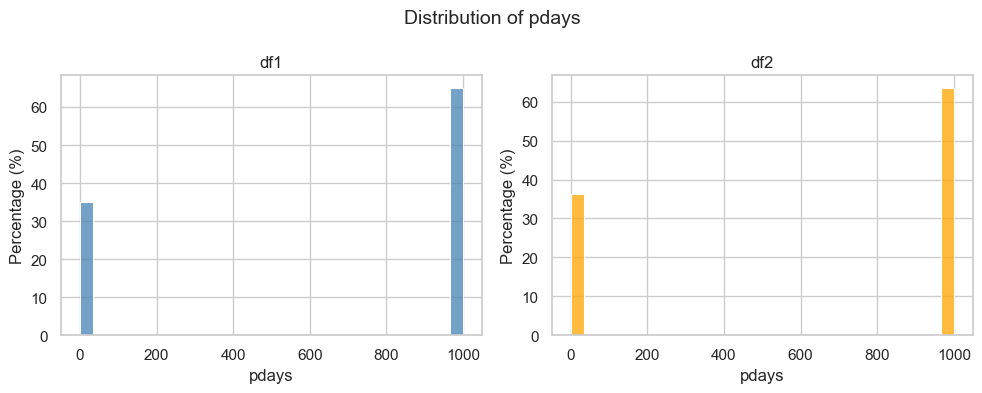

Bins for 'pdays': [  0.   33.3  66.6  99.9 133.2 166.5 199.8 233.1 266.4 299.7 333.  366.3
 399.6 432.9 466.2 499.5 532.8 566.1 599.4 632.7 666.  699.3 732.6 765.9
 799.2 832.5 865.8 899.1 932.4 965.7 999. ]


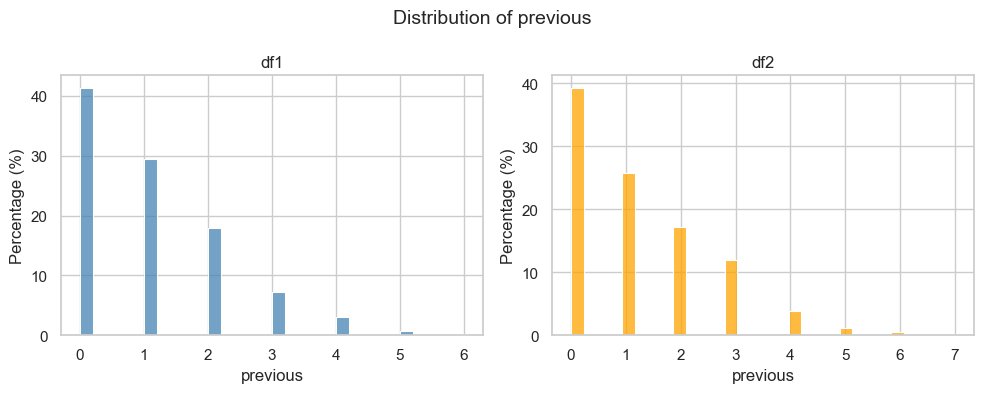

Bins for 'previous': [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6. ]


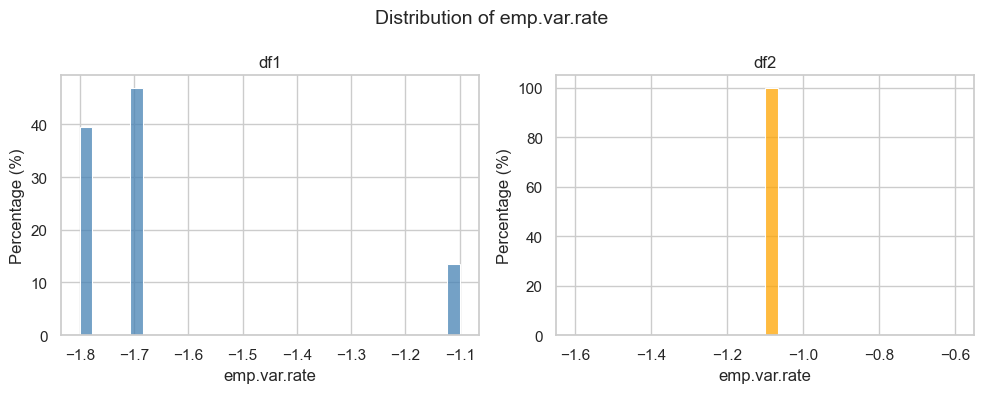

Bins for 'emp.var.rate': [-1.8        -1.77666667 -1.75333333 -1.73       -1.70666667 -1.68333333
 -1.66       -1.63666667 -1.61333333 -1.59       -1.56666667 -1.54333333
 -1.52       -1.49666667 -1.47333333 -1.45       -1.42666667 -1.40333333
 -1.38       -1.35666667 -1.33333333 -1.31       -1.28666667 -1.26333333
 -1.24       -1.21666667 -1.19333333 -1.17       -1.14666667 -1.12333333
 -1.1       ]


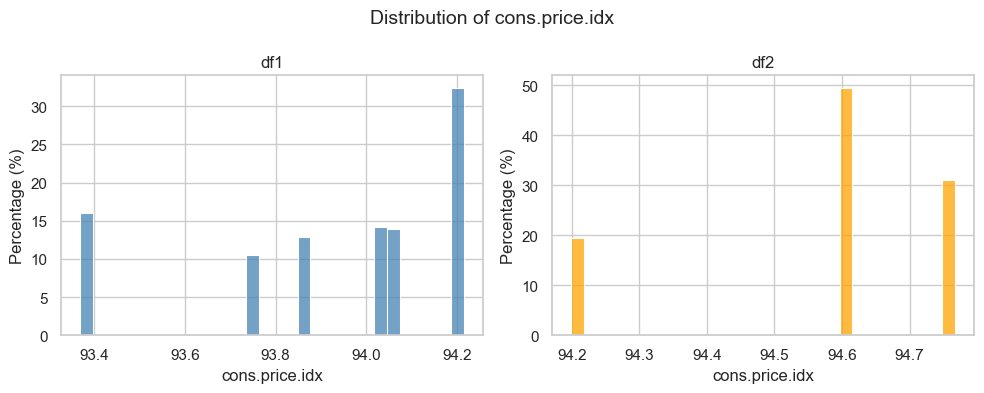

Bins for 'cons.price.idx': [93.369  93.3972 93.4254 93.4536 93.4818 93.51   93.5382 93.5664 93.5946
 93.6228 93.651  93.6792 93.7074 93.7356 93.7638 93.792  93.8202 93.8484
 93.8766 93.9048 93.933  93.9612 93.9894 94.0176 94.0458 94.074  94.1022
 94.1304 94.1586 94.1868 94.215 ]


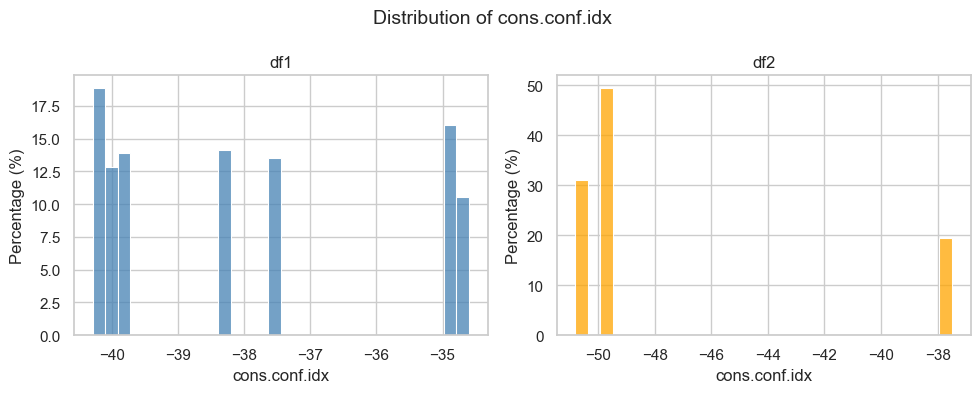

Bins for 'cons.conf.idx': [-40.3  -40.11 -39.92 -39.73 -39.54 -39.35 -39.16 -38.97 -38.78 -38.59
 -38.4  -38.21 -38.02 -37.83 -37.64 -37.45 -37.26 -37.07 -36.88 -36.69
 -36.5  -36.31 -36.12 -35.93 -35.74 -35.55 -35.36 -35.17 -34.98 -34.79
 -34.6 ]


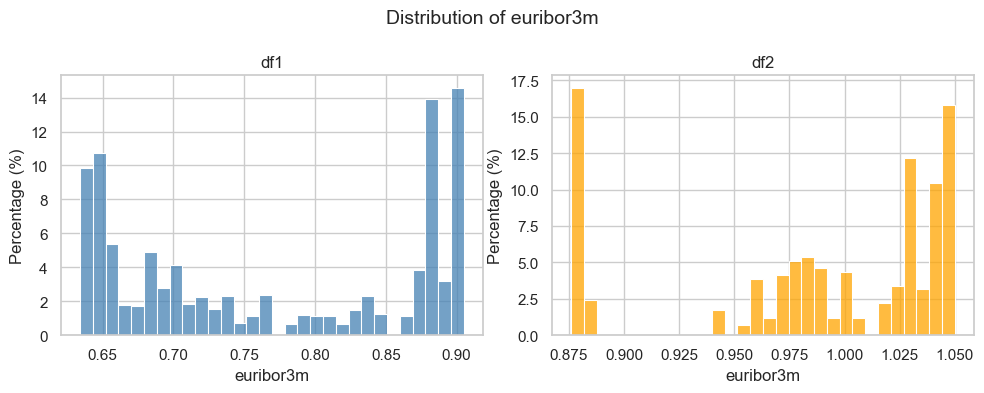

Bins for 'euribor3m': [0.634      0.64303333 0.65206667 0.6611     0.67013333 0.67916667
 0.6882     0.69723333 0.70626667 0.7153     0.72433333 0.73336667
 0.7424     0.75143333 0.76046667 0.7695     0.77853333 0.78756667
 0.7966     0.80563333 0.81466667 0.8237     0.83273333 0.84176667
 0.8508     0.85983333 0.86886667 0.8779     0.88693333 0.89596667
 0.905     ]


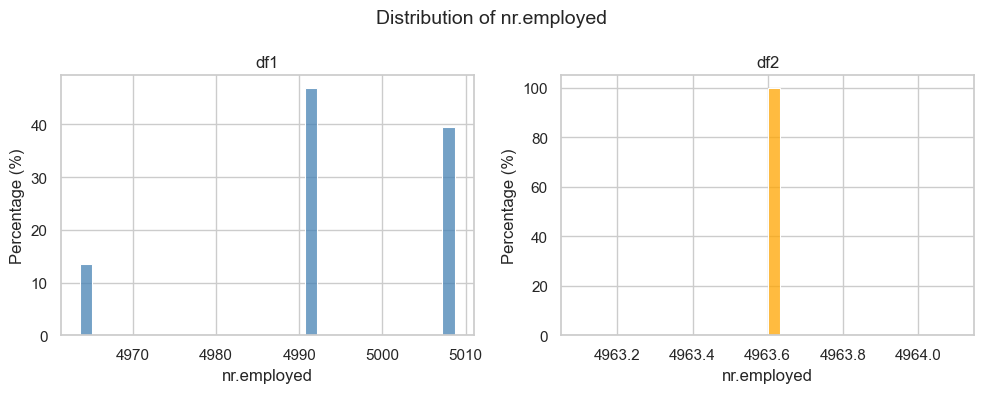

Bins for 'nr.employed': [4963.6        4965.10333333 4966.60666667 4968.11       4969.61333333
 4971.11666667 4972.62       4974.12333333 4975.62666667 4977.13
 4978.63333333 4980.13666667 4981.64       4983.14333333 4984.64666667
 4986.15       4987.65333333 4989.15666667 4990.66       4992.16333333
 4993.66666667 4995.17       4996.67333333 4998.17666667 4999.68
 5001.18333333 5002.68666667 5004.19       5005.69333333 5007.19666667
 5008.7       ]


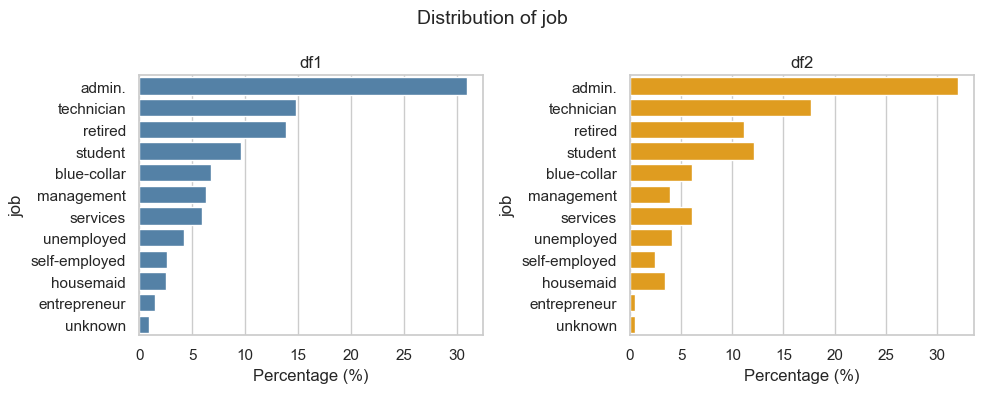

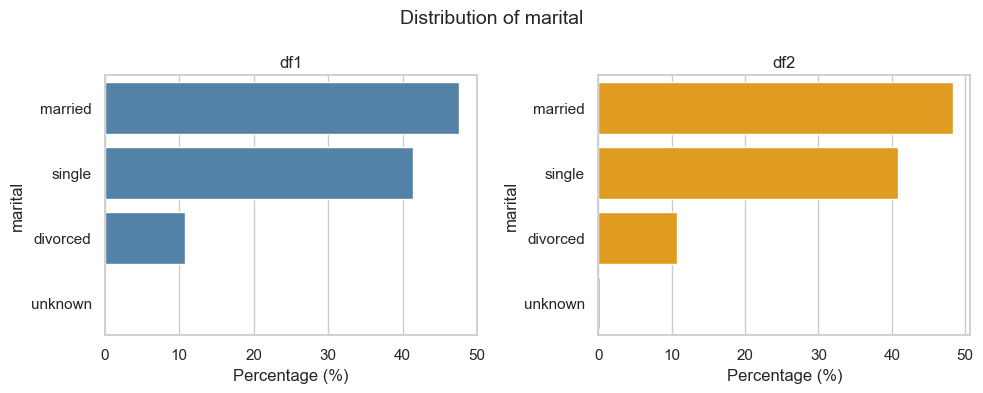

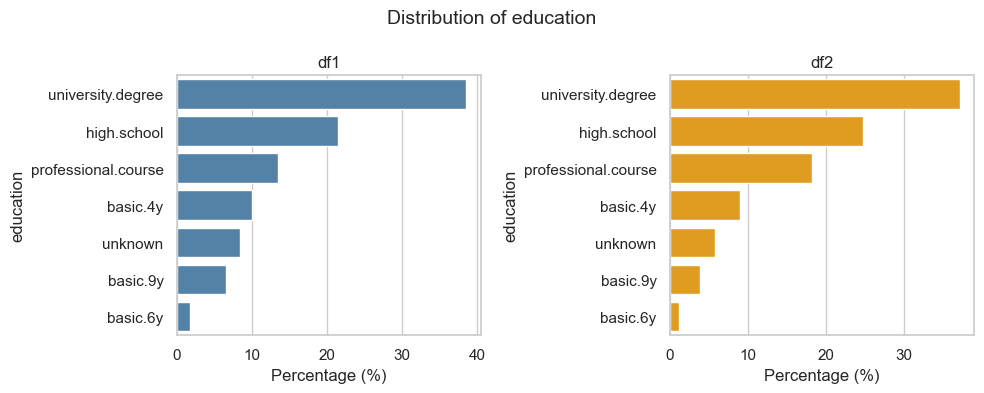

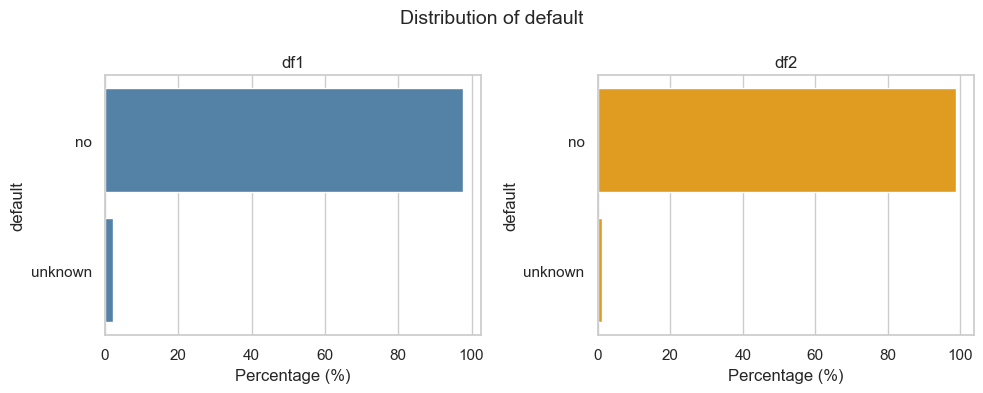

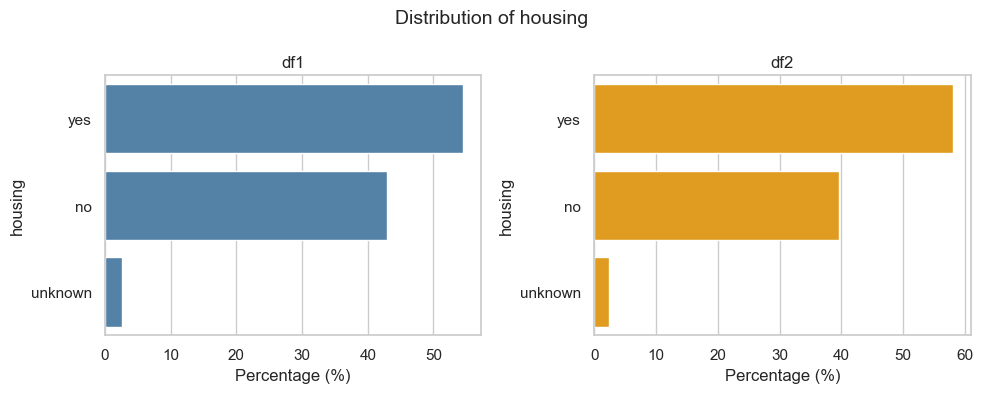

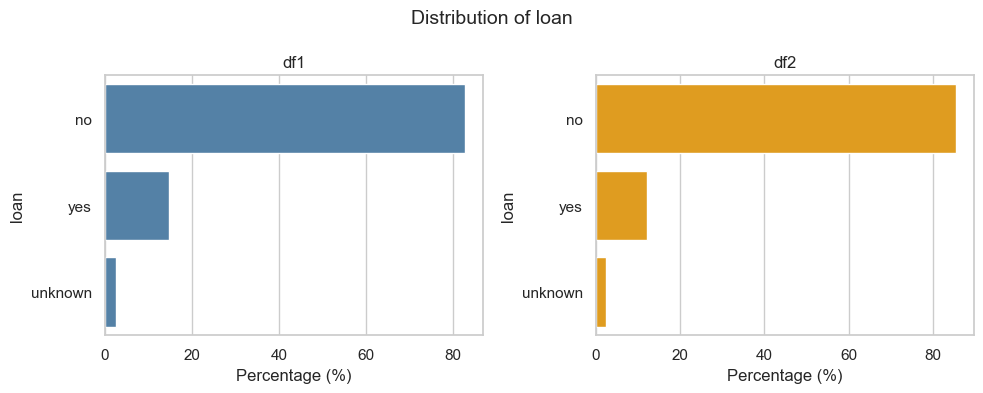

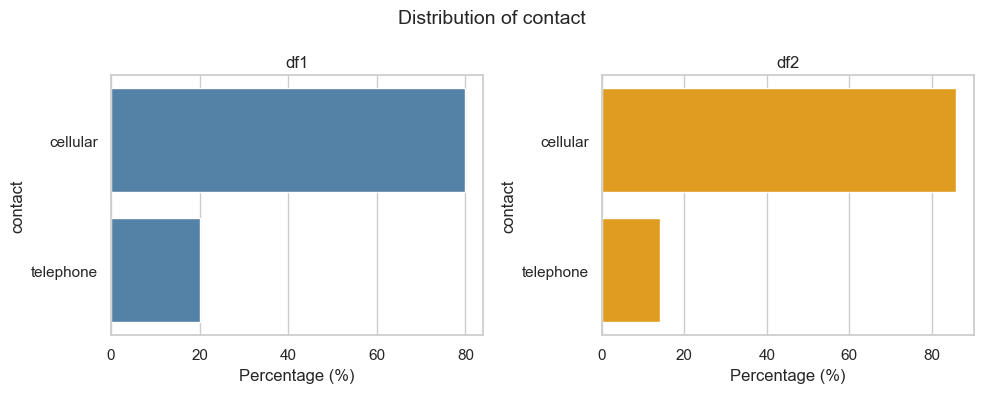

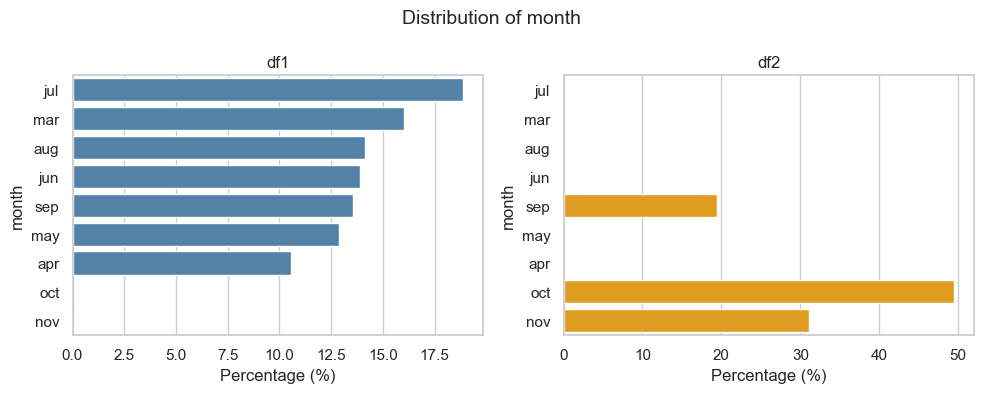

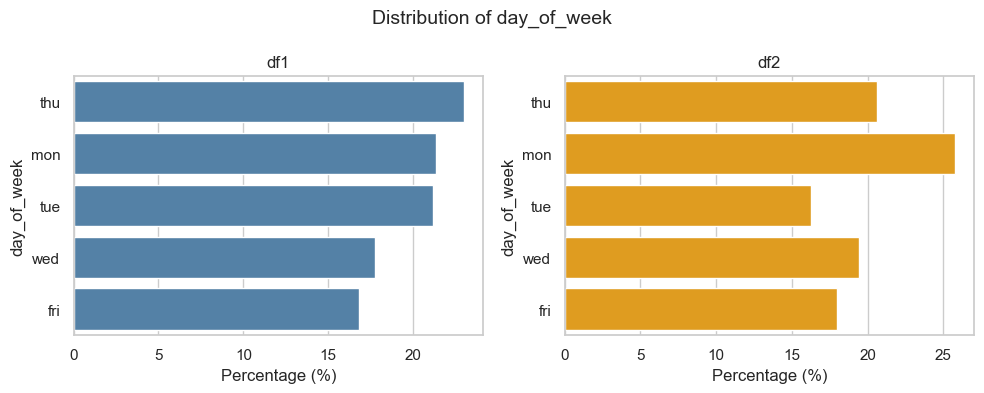

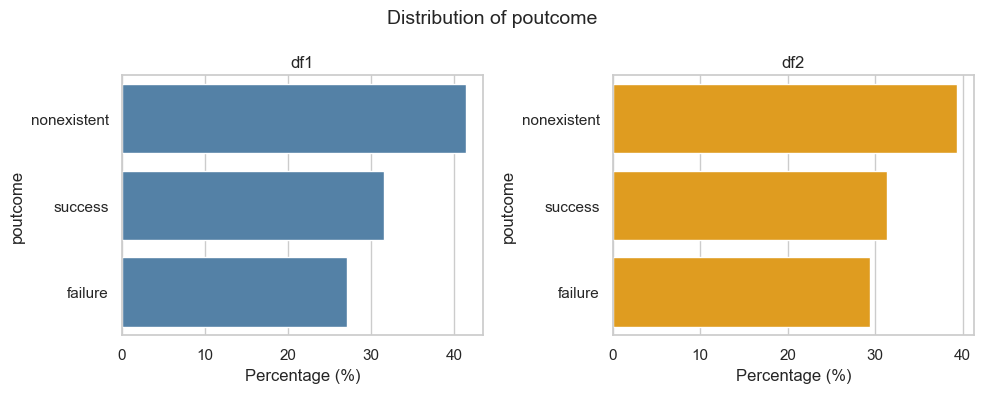

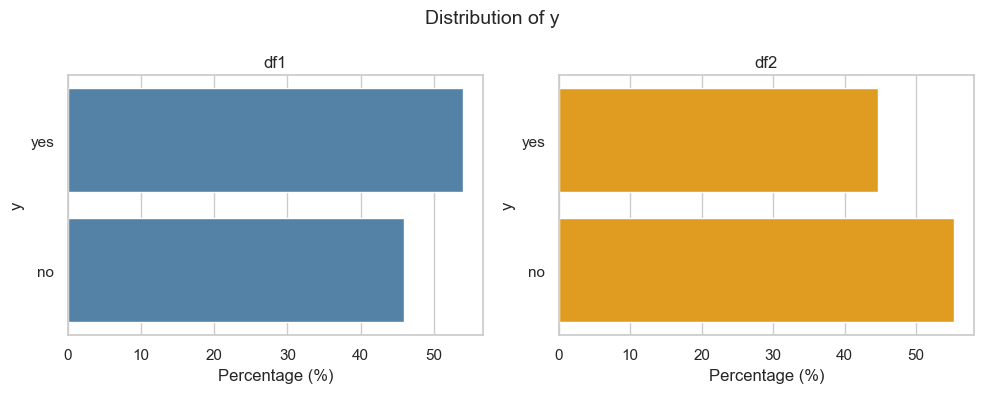

In [77]:
compare_distributions(train_set_cut, test_set_cut, 30)

# Population Stability Index on cut dataset

In [78]:
num_cols = train_set_cut.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train_set_cut.select_dtypes(include=["category", "object"]).columns.tolist()

print(num_cols)
print(cat_cols)

results = []

# Compute PSI - num
for col in num_cols:
    psi_val = psi(train_set_cut[col].dropna(), test_set_cut[col].dropna(), n_bins=30)
    results.append(psi_val)

# Compute PSI - cat
for col in cat_cols:
    psi_val = psi(train_set_cut[col], test_set_cut[col], n_bins=30)
    results.append(psi_val)

psi_outputs["Psi_cut"] = results
psi_outputs

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


,Feature,Psi,Psi_cut
0,age,0.352378,0.231706
1,duration,0.022452,0.050973
2,campaign,0.081058,0.055780
3,pdays,0.461901,0.000948
4,previous,0.940028,0.036581
5,emp.var.rate,8.727344,8.967103
6,cons.price.idx,10.530461,4.939348
7,cons.conf.idx,10.678185,6.318256
8,euribor3m,7.361996,5.177698
9,nr.employed,7.978768,8.967103


### Observation :

Compared to the previous PSI computation, the one on the cut dataset is much more reassuring.

New populations are more similar overall, except for macroeconomical features where drift is still extremely significant.

Drift for month is expected since the period has shifted.

# Correlation Matric on cut dataset

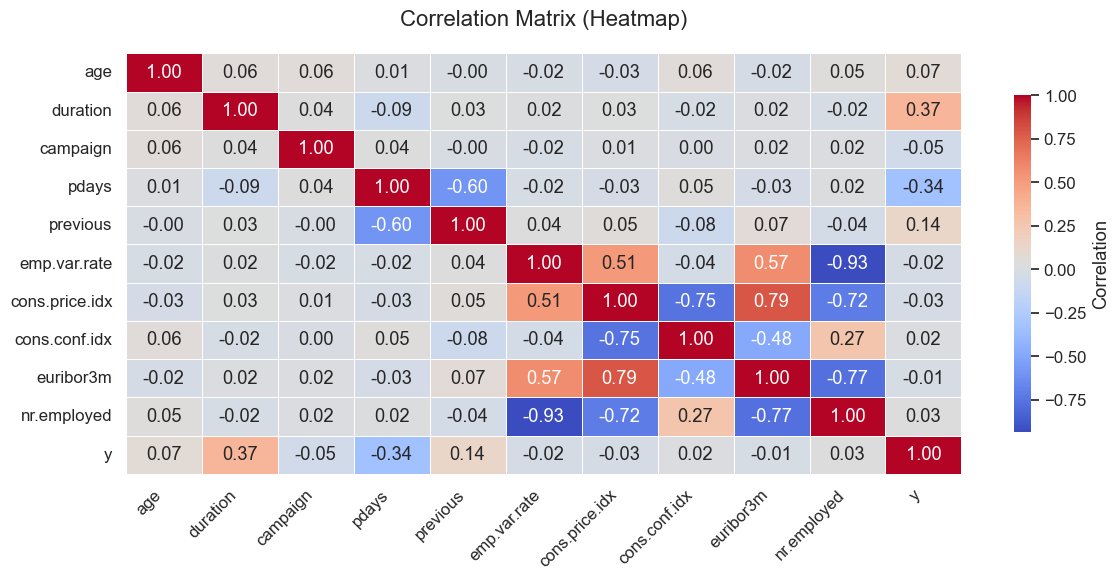

In [79]:
data = train_set_cut.copy()
data.y = data.y.map({"yes": 1, "no": 0})
num_cols = data.select_dtypes(include=["number"]).columns.tolist()

corr = data[num_cols].corr(method="pearson")

plot_heatmap(corr, "Correlation Matrix (Heatmap)")

# Cramer's V on cut dataset

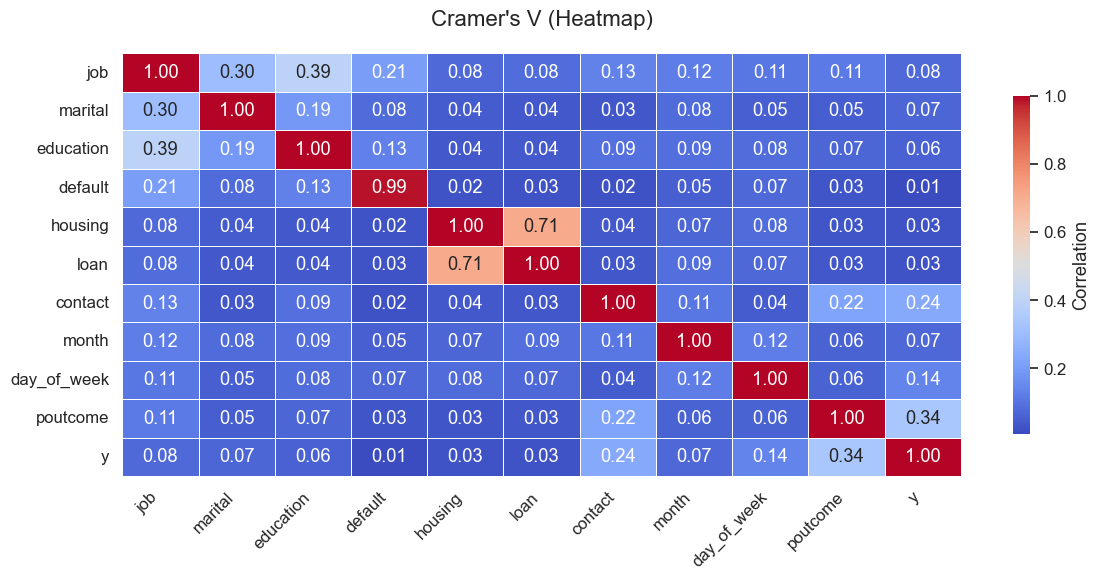

In [80]:
data = train_set_cut.copy()
cat_cols = data.select_dtypes(include=["object", "category"]).columns.tolist()
bank_cat = data[cat_cols]

cramers_outputs = [[cramers_v(bank_cat[col_i], bank_cat[col_j]) for col_j in cat_cols] for col_i in cat_cols]

cramers_df = pd.DataFrame(cramers_outputs, columns = cat_cols, index = cat_cols)
plot_heatmap(cramers_df, "Cramer's V (Heatmap)")